Transfer learning, fine tuning of ResNet50 with FastAI

In [1]:
import fastai; fastai.__version__

Load and inspect data. The folder structure is CANCER2/train/'folder for each class (B,IS,IV,N)' and CANCER2/valid/'folder for each class (B,IS,IV,N)'
(PS. The function get_transforms() lets you do automatic data augmentation - not used below (empty))

In [2]:
from fastai.basics import *
from fastai.vision import ImageDataBunch
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

np.random.seed(42)
data = ImageDataBunch.from_folder('CANCER2', train='train', valid='valid',
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [3]:
data.classes

['B', 'IS', 'IV', 'N']

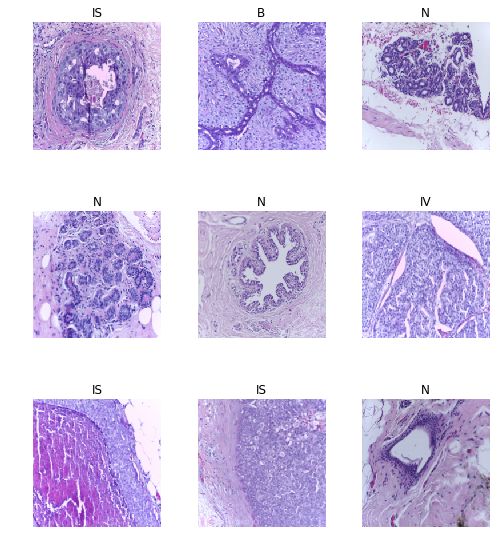

In [4]:
data.show_batch(rows=3, figsize=(7, 8))

STEP 1 - train classification layers - see slides

In [5]:
from tensorflow.python.keras.models import Model
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=ShowGraph)

In [6]:
learn.data.batch_size = 16

epoch,train_loss,valid_loss,error_rate,time
0,1.296551,0.717437,0.212500,00:56
1,1.074718,0.541047,0.187500,00:51
2,0.918238,0.552557,0.262500,00:51
3,0.828361,0.536030,0.162500,00:52
4,0.712650,0.514875,0.150000,00:57
5,0.627037,0.484918,0.150000,00:59
6,0.543186,0.488715,0.150000,00:56
7,0.501985,0.510409,0.162500,00:53


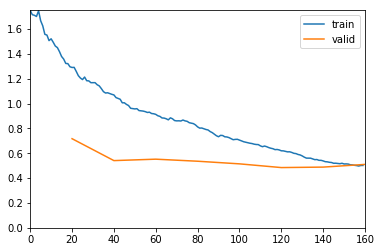

In [7]:
learn.fit_one_cycle(8)

In [8]:
preds,y,losses = learn.get_preds(DatasetType.Valid,with_loss=True)
acc = accuracy(preds, y)

In [9]:
from sklearn.metrics import classification_report
report = classification_report(np.asarray(y), np.asarray(preds).argmax(axis=-1), digits=4)
print(f'\nClassification_report=\n{report}')


Classification_report=
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667        20
           1     0.8636    0.9500    0.9048        20
           2     0.8571    0.9000    0.8780        20
           3     0.7407    1.0000    0.8511        20

   micro avg     0.8375    0.8375    0.8375        80
   macro avg     0.8654    0.8375    0.8251        80
weighted avg     0.8654    0.8375    0.8251        80



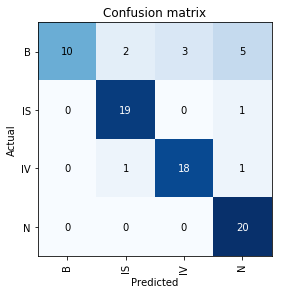

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [11]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))

['B', 'IS', 'IV', 'N'] 4 320 80


Look at problematic images

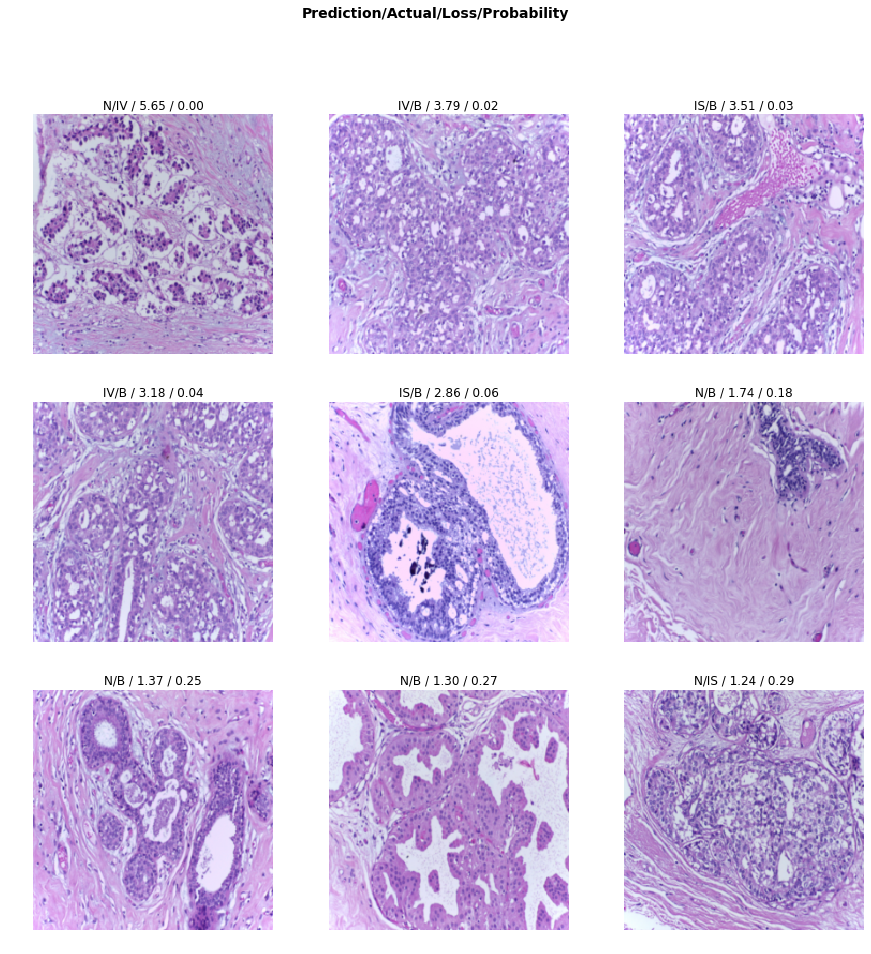

In [12]:
interp.plot_top_losses(9, figsize=(15,15))

STEP 2 - fine tune feature learning layers - see slides

In [13]:
learn.data.batch_size = 16

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


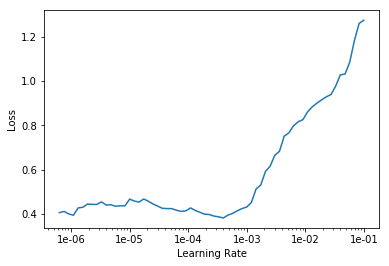

In [14]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.166228,0.500123,0.175000,00:58
1,0.138187,0.537334,0.187500,00:57
2,0.201283,1.971786,0.300000,00:56
3,0.329574,0.866037,0.200000,00:56
4,0.332733,0.420154,0.150000,01:00
5,0.266416,0.396866,0.150000,00:54
6,0.210850,0.391563,0.150000,00:55


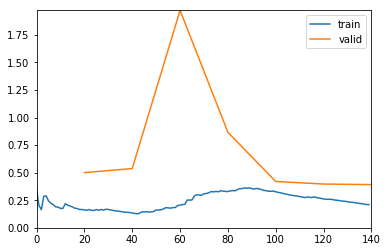

In [22]:
learn.fit_one_cycle(7, max_lr=slice(1e-4, 1e-3))

In [23]:
preds,y,losses = learn.get_preds(DatasetType.Valid,with_loss=True)
acc = accuracy(preds, y)

In [24]:
from sklearn.metrics import classification_report
report = classification_report(np.asarray(y), np.asarray(preds).argmax(axis=-1), digits=4)
print(f'\nClassification_report=\n{report}')


Classification_report=
              precision    recall  f1-score   support

           0     0.8750    0.7000    0.7778        20
           1     0.7917    0.9500    0.8636        20
           2     0.8500    0.8500    0.8500        20
           3     0.9000    0.9000    0.9000        20

   micro avg     0.8500    0.8500    0.8500        80
   macro avg     0.8542    0.8500    0.8479        80
weighted avg     0.8542    0.8500    0.8479        80



In [18]:
img = data.valid_ds[0][0]
learn.predict(img)

(Category N, tensor(3), tensor([0.0241, 0.0409, 0.0010, 0.9340]))